# Green AI and Climate Tech Analysis

## Table of Contents
1. [Setup and Data Loading](#setup)
2. [Data Cleaning and Preparation](#cleaning)
3. [Regional Carbon Intensity Analysis](#regional)
4. [ML System Power Analysis](#power)
5. [Carbon Impact Calculations](#carbon)
6. [Performance vs Efficiency Analysis](#performance)
7. [Recommendations and Conclusions](#conclusions)

## Introduction
This notebook analyzes the environmental impact of modern AI systems, focusing on power consumption, carbon emissions, and efficiency metrics. We examine how different hardware configurations and geographical locations affect the carbon footprint of AI workloads.


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os
images_dir = '../images/analysis'
os.makedirs(images_dir, exist_ok=True)

# Set up plotting styles
plt.style.use('seaborn-v0_8-darkgrid')  # or 'seaborn-v0_8-whitegrid'
sns.set_palette('viridis')

# Set random seed for reproducibility
np.random.seed(42)

## Data Loading and Cleaning
Our analysis uses two primary datasets:
1. eGRID data: Contains CO2 emissions rates for power plants across the United States
2. MLPerf data: Provides system configurations and performance metrics for various AI systems

The data cleaning process includes:
- Removing outliers using z-score analysis
- Handling missing values
- Normalizing power and emissions metrics

In [2]:
def load_and_clean_data():
    """Load and clean both datasets"""
    # Load eGRID data
    egrid_df = pd.read_excel('../data/egrid2022_data.xlsx', sheet_name='PLNT22')
    
    # Load MLPerf data
    mlperf_df = pd.read_csv('../data/mlperf_inference_clean.csv')
    
    # Clean eGRID data
    emissions_col = 'Plant annual CO2 total output emission rate (lb/MWh)'
    location_col = 'Plant state abbreviation'
    
    egrid_clean = egrid_df[egrid_df[location_col] != 'PSTATABB'].copy()
    egrid_clean[emissions_col] = pd.to_numeric(egrid_clean[emissions_col], errors='coerce')
    
    # Remove outliers using z-score
    emissions_data = egrid_clean[emissions_col].dropna()
    z_scores = np.abs(stats.zscore(emissions_data))
    egrid_clean.loc[emissions_data[z_scores > 3].index, emissions_col] = np.nan
    
    return egrid_clean, mlperf_df

# Load and clean data
egrid_df, mlperf_df = load_and_clean_data()

# Display basic information
print("eGRID Data Summary:")
print(f"Total plants: {len(egrid_df)}")
print(f"Plants with valid emission rates: {egrid_df['Plant annual CO2 total output emission rate (lb/MWh)'].notna().sum()}")

print("\nMLPerf Data Summary:")
print(f"Total systems: {len(mlperf_df['System Name (click + for details)'].unique())}")
print(f"Unique accelerator types: {mlperf_df['Accelerator'].nunique()}")

eGRID Data Summary:
Total plants: 11973
Plants with valid emission rates: 3572

MLPerf Data Summary:
Total systems: 61
Unique accelerator types: 15


In [3]:
# Detailed eGRID Analysis
emissions_col = 'Plant annual CO2 total output emission rate (lb/MWh)'
location_col = 'Plant state abbreviation'

# Calculate state-level statistics
state_stats = egrid_df.groupby(location_col).agg({
    emissions_col: ['count', 'mean', 'std', 'min', 'max']
}).round(2)

# Sort by mean emissions
state_stats = state_stats.sort_values((emissions_col, 'mean'), ascending=False)

print("Top 5 States by Average Emissions Rate:")
print(state_stats.head())
print("\nBottom 5 States by Average Emissions Rate:")
print(state_stats.tail())

Top 5 States by Average Emissions Rate:
                         Plant annual CO2 total output emission rate (lb/MWh)  \
                                                                        count   
Plant state abbreviation                                                        
KS                                                                       92     
CT                                                                       58     
MO                                                                       72     
UT                                                                       37     
VT                                                                       12     

                                                           
                             mean      std  min       max  
Plant state abbreviation                                   
KS                        2266.76  3328.86  0.0  27411.54  
CT                        2211.77  4258.50  0.0  31840.52  
MO         

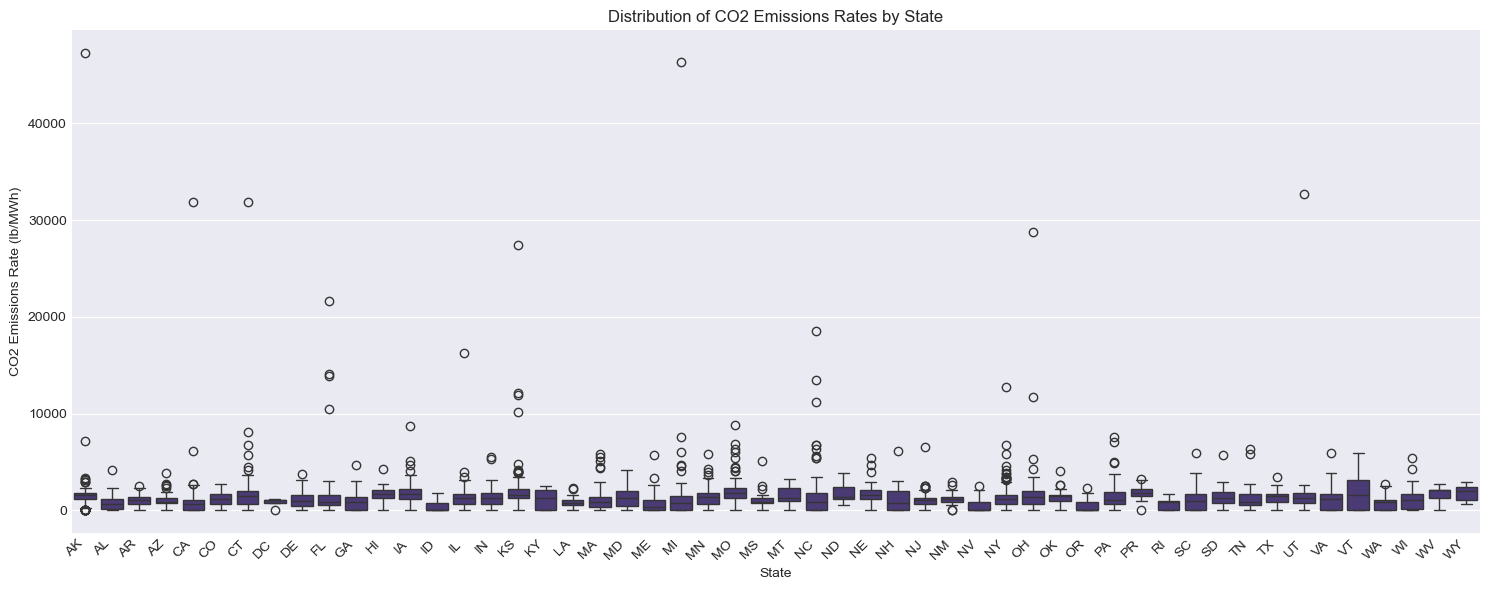

In [4]:
# Visualize regional emissions distribution
plt.figure(figsize=(15, 6))
sns.boxplot(data=egrid_df, x=location_col, y=emissions_col)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of CO2 Emissions Rates by State')
plt.xlabel('State')
plt.ylabel('CO2 Emissions Rate (lb/MWh)')
plt.tight_layout()
plt.show()

In [5]:
# Analyze MLPerf systems
print("\nMLPerf System Analysis:")
print("\nAccelerator Distribution:")
print(mlperf_df['Accelerator'].value_counts().head())

print("\nProcessor Distribution:")
print(mlperf_df['Processor'].value_counts().head())

# Create pivot table of system configurations
system_configs = mlperf_df.pivot_table(
    index='System Name (click + for details)',
    values=['# of Accelerators', 'Host Processor Core Count'],
    aggfunc='first'
).round(2)

print("\nSystem Configurations:")
print(system_configs.head())


MLPerf System Analysis:

Accelerator Distribution:
Accelerator
NVIDIA H100-SXM-80GB     274
NVIDIA H200-SXM-141GB    112
NVIDIA L40S               82
NVIDIA H100-NVL-94GB      74
NVIDIA H100-PCIe-80GB     70
Name: count, dtype: int64

Processor Distribution:
Processor
Intel(R) Xeon(R) Platinum 8468     118
INTEL(R) XEON(R) PLATINUM 8592+     78
NVIDIA Grace CPU                    72
Intel(R) Xeon(R) Platinum 8480C     58
Intel(R) Xeon(R) Platinum 8480+     34
Name: count, dtype: int64

System Configurations:
                                                 # of Accelerators  \
System Name (click + for details)                                    
1-node-2S-EMR-PyTorch                                            0   
1-node-2S-GNR-PyTorch                                            0   
2x8xH100-SXM-80GB                                                8   
4x8xH100-SXM-80GB                                                8   
AS-4125GS-TNHR2-LCC (8x H100-SXM-80GB TensorRT)                  

In [6]:
# Power consumption estimates for different accelerators (Watts)
accelerator_power = {
    'H100-SXM': 700,    # SXM variant has higher TDP
    'H100-PCIe': 350,   # PCIe variant is more power-efficient
    'H200-SXM': 700,    # Similar to H100-SXM
    'L40S': 300,        # Professional visualization GPU
    'H100-NVL': 400     # Network variant
}

def estimate_system_power(row):
    """Estimate total system power consumption"""
    # Base system power
    base_power = 200  # Watts
    
    # CPU power estimation (5W per core as a rough estimate)
    cpu_power = float(row['Host Processor Core Count']) * 5 if pd.notna(row['Host Processor Core Count']) else 150
    
    # Accelerator power
    acc_power = 0
    if pd.notna(row['Accelerator']) and pd.notna(row['# of Accelerators']):
        acc_name = str(row['Accelerator'])
        acc_count = float(row['# of Accelerators'])
        
        for acc_type, power in accelerator_power.items():
            if acc_type in acc_name:
                acc_power = power * acc_count
                break
    
    total_power = base_power + cpu_power + acc_power
    return pd.Series({
        'base_power': base_power,
        'cpu_power': cpu_power,
        'accelerator_power': acc_power,
        'total_power': total_power
    })

# Calculate power consumption for each system
power_analysis = mlperf_df.apply(estimate_system_power, axis=1)
mlperf_df = pd.concat([mlperf_df, power_analysis], axis=1)

# Display top systems by power consumption
top_power_systems = mlperf_df.nlargest(10, 'total_power')[
    ['System Name (click + for details)', 'total_power', 'base_power', 'cpu_power', 'accelerator_power']
].drop_duplicates()

print("Top 10 Systems by Power Consumption (Watts):")
print(top_power_systems.round(2))

Top 10 Systems by Power Consumption (Watts):
                   System Name (click + for details)  total_power  base_power  \
406                                2x8xH100-SXM-80GB       6360.0       200.0   
410                                4x8xH100-SXM-80GB       6360.0       200.0   
629  AS-4125GS-TNHR2-LCC (8x H100-SXM-80GB TensorRT)       6280.0       200.0   

     cpu_power  accelerator_power  
406      560.0             5600.0  
410      560.0             5600.0  
629      480.0             5600.0  


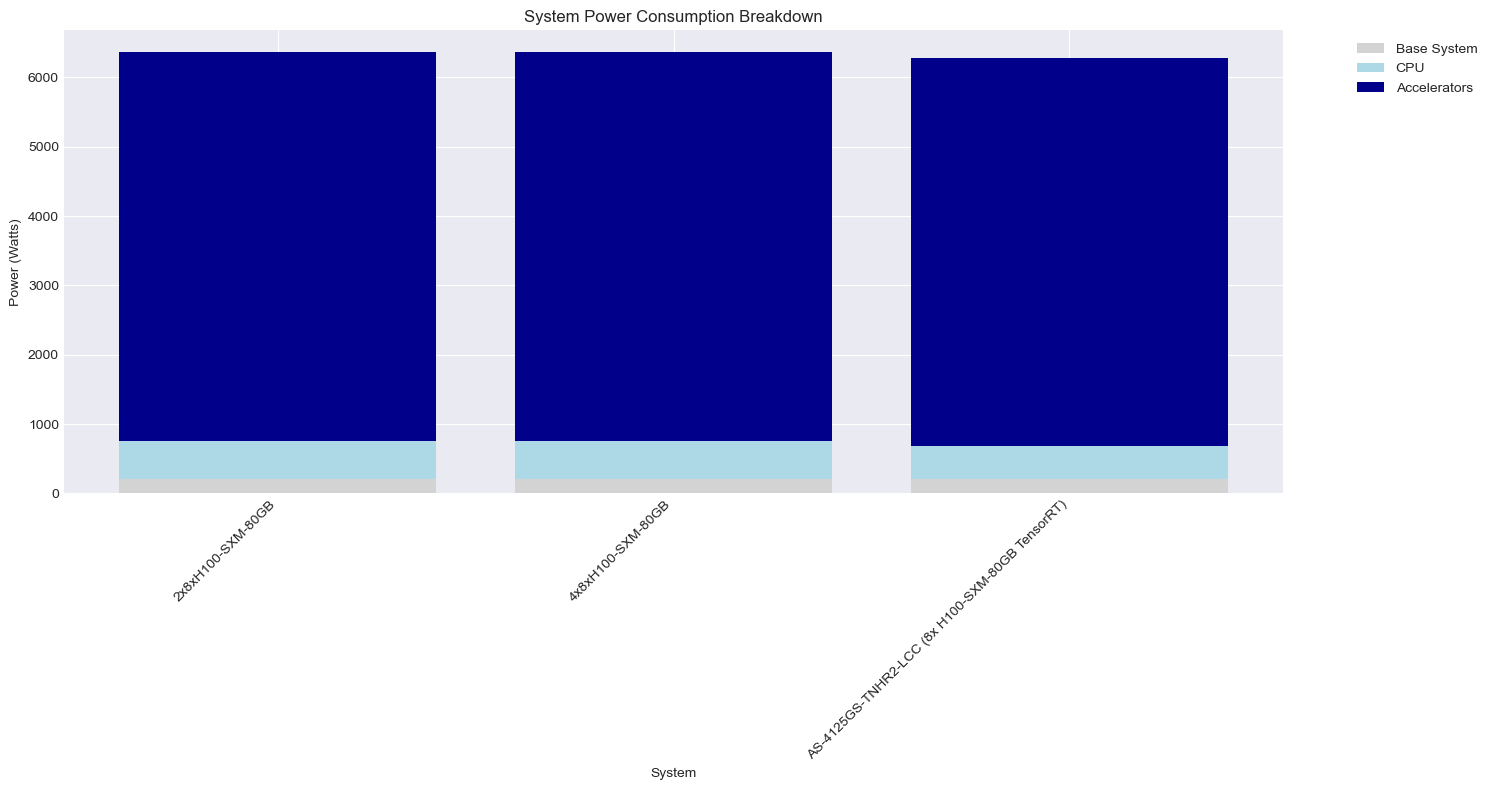

In [7]:
# Visualize power distribution across components
plt.figure(figsize=(15, 8))
data = top_power_systems.copy()
data = data.set_index('System Name (click + for details)')

# Create stacked bar chart
bottom = np.zeros(len(data))
components = ['base_power', 'cpu_power', 'accelerator_power']
colors = ['lightgrey', 'lightblue', 'darkblue']
labels = ['Base System', 'CPU', 'Accelerators']

for component, color, label in zip(components, colors, labels):
    plt.bar(data.index, data[component], bottom=bottom, label=label, color=color)
    bottom += data[component]

plt.xticks(rotation=45, ha='right')
plt.title('System Power Consumption Breakdown')
plt.xlabel('System')
plt.ylabel('Power (Watts)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

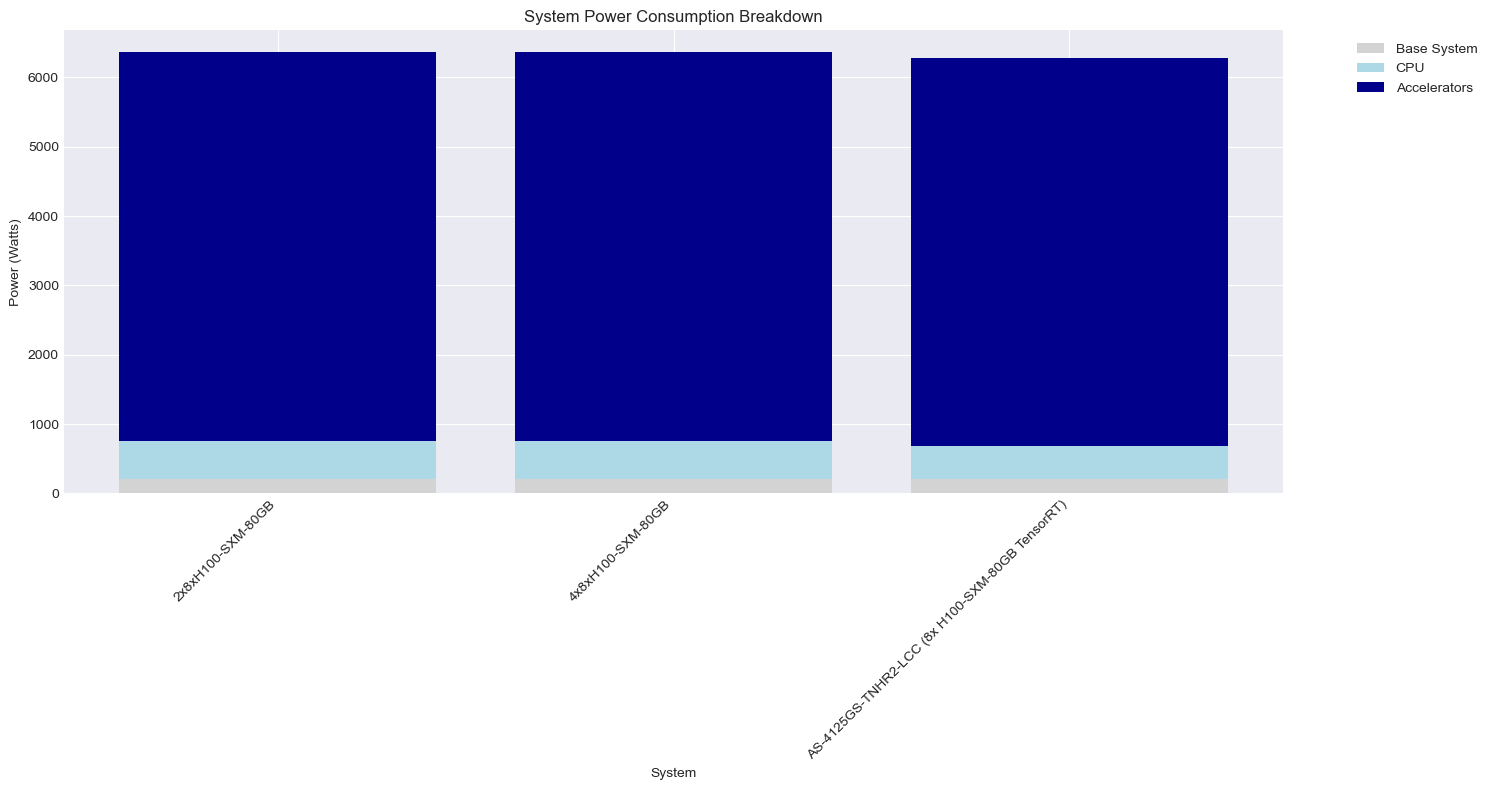

In [8]:
# Visualize power distribution across components
plt.figure(figsize=(15, 8))
data = top_power_systems.copy()
data = data.set_index('System Name (click + for details)')

# Create stacked bar chart
bottom = np.zeros(len(data))
components = ['base_power', 'cpu_power', 'accelerator_power']
colors = ['lightgrey', 'lightblue', 'darkblue']
labels = ['Base System', 'CPU', 'Accelerators']

for component, color, label in zip(components, colors, labels):
    plt.bar(data.index, data[component], bottom=bottom, label=label, color=color)
    bottom += data[component]

plt.xticks(rotation=45, ha='right')
plt.title('System Power Consumption Breakdown')
plt.xlabel('System')
plt.ylabel('Power (Watts)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [9]:
# Calculate daily carbon impact for different regions
def calculate_daily_carbon(power_w, emission_rate_lb_mwh):
    """Calculate daily CO2 emissions in pounds"""
    daily_mwh = (power_w * 24) / 1_000_000  # Convert W to MWh for 24 hours
    return daily_mwh * emission_rate_lb_mwh

# Get average emission rates for top and bottom states
top_emissions_state = state_stats.index[0]
bottom_emissions_state = state_stats.index[-1]

top_rate = state_stats.loc[top_emissions_state, (emissions_col, 'mean')]
bottom_rate = state_stats.loc[bottom_emissions_state, (emissions_col, 'mean')]

# Calculate impact for each system
impact_analysis = top_power_systems.copy()
impact_analysis['daily_co2_high'] = impact_analysis['total_power'].apply(
    lambda x: calculate_daily_carbon(x, top_rate)
)
impact_analysis['daily_co2_low'] = impact_analysis['total_power'].apply(
    lambda x: calculate_daily_carbon(x, bottom_rate)
)

print(f"\nDaily CO2 Impact Analysis (comparing {top_emissions_state} vs {bottom_emissions_state}):")
print(impact_analysis[['System Name (click + for details)', 'daily_co2_high', 'daily_co2_low']].round(2))


Daily CO2 Impact Analysis (comparing KS vs OR):
                   System Name (click + for details)  daily_co2_high  \
406                                2x8xH100-SXM-80GB          346.00   
410                                4x8xH100-SXM-80GB          346.00   
629  AS-4125GS-TNHR2-LCC (8x H100-SXM-80GB TensorRT)          341.65   

     daily_co2_low  
406          65.80  
410          65.80  
629          64.97  


## Efficiency Analysis
We examine the power efficiency of different AI accelerators and system configurations, calculating:
- Watts per accelerator
- CO2 emissions per accelerator
- Total system efficiency
This helps identify the most environmentally efficient hardware configurations.

Efficiency Analysis by Accelerator Type:

Power and Carbon Efficiency Metrics:
                                          watts_per_accelerator                \
                                                          count   mean    min   
Accelerator                                                                     
AMD Instinct MI300X-NPS1-SPX-192GB-750W                       0    NaN    NaN   
AMD MI300X-NPS1-SPX-192GB-750W                                0    NaN    NaN   
NVIDIA B200-SXM-180GB                                         0    NaN    NaN   
NVIDIA GH200 Grace Hopper Superchip 144GB                     0    NaN    NaN   
NVIDIA GH200 Grace Hopper Superchip 96GB                      0    NaN    NaN   
NVIDIA H100-NVL-94GB                                         74  400.0  400.0   
NVIDIA H100-PCIe-80GB                                        70  350.0  350.0   
NVIDIA H100-SXM-80GB                                        274  700.0  700.0   
NVIDIA H200-SXM-141GB         

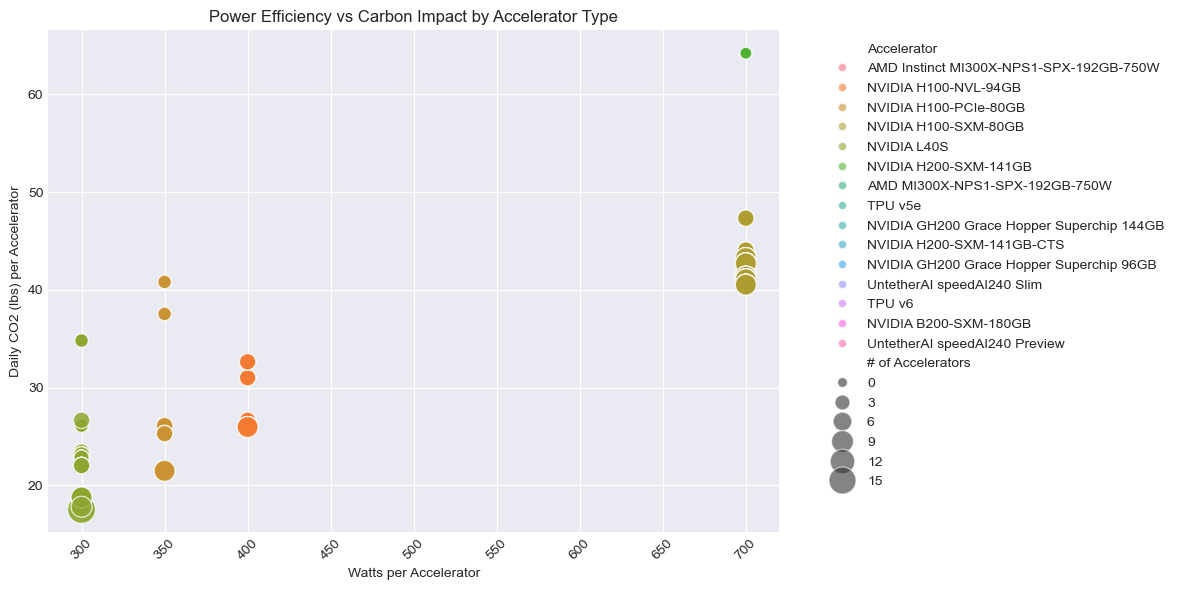

In [14]:
# First, let's ensure we have our power and carbon calculations properly integrated
def calculate_efficiency_metrics(df):
    """Calculate efficiency metrics for ML systems"""
    # Create a copy to avoid modifications to original
    df = df.copy()
    
    # Power per accelerator
    mask = (df['# of Accelerators'] > 0) & (df['accelerator_power'] > 0)
    df.loc[mask, 'watts_per_accelerator'] = df.loc[mask, 'accelerator_power'] / df.loc[mask, '# of Accelerators']
    
    # Calculate CO2 impact for each system (using KS emissions rate as worst case)
    ks_emission_rate = 2266.76  # From our previous analysis
    daily_mwh = (df['total_power'] * 24) / 1_000_000  # Convert W to MWh for 24 hours
    df['daily_co2'] = daily_mwh * ks_emission_rate
    
    # Calculate CO2 per accelerator
    df.loc[mask, 'co2_per_accelerator'] = df.loc[mask, 'daily_co2'] / df.loc[mask, '# of Accelerators']
    
    return df

# Apply efficiency calculations
efficiency_metrics = calculate_efficiency_metrics(mlperf_df)

# Group by accelerator type and calculate statistics
efficiency_summary = efficiency_metrics.groupby('Accelerator').agg({
    'watts_per_accelerator': ['count', 'mean', 'min', 'max'],
    'co2_per_accelerator': ['mean', 'min', 'max']
}).round(2)

print("Efficiency Analysis by Accelerator Type:")
print("\nPower and Carbon Efficiency Metrics:")
print(efficiency_summary)

# Additional analysis of accelerator types
print("\nDetailed Accelerator Analysis:")
accelerator_analysis = efficiency_metrics.groupby('Accelerator').agg({
    'total_power': 'mean',
    'watts_per_accelerator': 'mean',
    'daily_co2': 'mean',
    '# of Accelerators': 'mean'
}).round(2)

print(accelerator_analysis.sort_values('total_power', ascending=False))

# Visualization with saving
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=efficiency_metrics,
    x='watts_per_accelerator',
    y='co2_per_accelerator',
    hue='Accelerator',
    size='# of Accelerators',
    sizes=(50, 400),
    alpha=0.6
)
plt.title('Power Efficiency vs Carbon Impact by Accelerator Type')
plt.xlabel('Watts per Accelerator')
plt.ylabel('Daily CO2 (lbs) per Accelerator')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(images_dir, 'efficiency_analysis.png'), 
            dpi=300, 
            bbox_inches='tight')
plt.show()

# Save the analysis results
efficiency_summary.to_csv(os.path.join(images_dir, 'efficiency_summary.csv'))
accelerator_analysis.to_csv(os.path.join(images_dir, 'accelerator_analysis.csv'))

## Geographic Impact Analysis
This section visualizes how location affects the environmental impact of AI systems. We create:
- Interactive choropleth maps of emissions rates
- Comparative analysis of system impacts across states
- Potential carbon savings through geographic optimization

In [16]:
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import requests

# Create images directory if it doesn't exist
import os
images_dir = '../images/analysis'
os.makedirs(images_dir, exist_ok=True)

def analyze_geographic_impact(state_stats, emissions_col):
    """Analyze and visualize geographic impact of ML systems"""
    print("Starting geographic impact analysis...")
    
    # Prepare emissions data
    state_impacts = pd.DataFrame(state_stats[emissions_col]['mean'])
    state_impacts.columns = ['emissions_rate']
    state_impacts['state'] = state_impacts.index
    
    print("\nCreating choropleth map...")
    
    # Create choropleth map using Plotly Express
    fig1 = px.choropleth(
        state_impacts,
        locations='state',
        locationmode='USA-states',
        color='emissions_rate',
        scope='usa',
        color_continuous_scale='Viridis',
        title='CO2 Emissions Rate by State (lb/MWh)',
        labels={'emissions_rate': 'CO2 Emissions Rate (lb/MWh)'}
    )
    
    # Customize layout
    fig1.update_layout(
        title_x=0.5,
        geo=dict(
            showlakes=True,
            lakecolor='rgb(255, 255, 255)'
        ),
        width=1000,
        height=600
    )
    
    # Display first figure
    fig1.show()
    
    print("Map created and displayed. Calculating system impacts...")
    
    # Calculate impact for different system sizes
    system_sizes = {
        'Small': 2000,    # 2kW system
        'Medium': 6000,   # 6kW system
        'Large': 12000    # 12kW system
    }
    
    impact_comparison = pd.DataFrame()
    for size, power in system_sizes.items():
        daily_mwh = (power * 24) / 1_000_000
        impact_comparison[f'{size}_System_CO2'] = state_impacts['emissions_rate'] * daily_mwh
    
    print("\nCreating impact comparison visualization...")
    
    # Create impact visualization
    fig2 = make_subplots(
        rows=2, cols=1,
        subplot_titles=(
            'Daily CO2 Impact by System Size and Location',
            'Potential CO2 Savings vs Highest Emission State'
        ),
        vertical_spacing=0.1
    )
    
    # Color scheme for different system sizes
    colors = {'Small': 'lightblue', 'Medium': 'blue', 'Large': 'darkblue'}
    
    # Add impact bars
    for size in system_sizes.keys():
        fig2.add_trace(
            go.Bar(
                name=size,
                x=impact_comparison.index,
                y=impact_comparison[f'{size}_System_CO2'],
                marker_color=colors[size],
                hovertemplate="State: %{x}<br>Daily CO2: %{y:.1f} lbs<extra></extra>"
            ),
            row=1, col=1
        )
    
    # Add savings potential
    for size in system_sizes.keys():
        max_impact = impact_comparison[f'{size}_System_CO2'].max()
        savings = max_impact - impact_comparison[f'{size}_System_CO2']
        fig2.add_trace(
            go.Bar(
                name=f'{size} Savings',
                x=impact_comparison.index,
                y=savings,
                marker_color=colors[size],
                hovertemplate="State: %{x}<br>Savings: %{y:.1f} lbs/day<extra></extra>"
            ),
            row=2, col=1
        )
    
    # Update layout
    fig2.update_layout(
        height=1200,
        showlegend=True,
        title_text="Geographic Impact Analysis of ML Systems",
        title_x=0.5,
        barmode='group'
    )
    
    # Update axes
    fig2.update_xaxes(tickangle=45)
    
    # Display second figure
    fig2.show()
    
    print("\nSaving visualizations...")
    # Save the figures
    fig1.write_html(os.path.join(images_dir, 'emissions_map.html'))
    fig2.write_html(os.path.join(images_dir, 'geographic_impact.html'))
    
    print("\nGenerating summary statistics...")
    # Additional summary statistics
    summary_stats = pd.DataFrame({
        'Metric': [
            'Highest Emissions State',
            'Lowest Emissions State',
            'Emissions Rate Difference',
            'Potential Daily Savings (Large System)',
            'States Above National Average',
            'States Below National Average'
        ],
        'Value': [
            state_impacts['emissions_rate'].idxmax(),
            state_impacts['emissions_rate'].idxmin(),
            f"{state_impacts['emissions_rate'].max() - state_impacts['emissions_rate'].min():.2f} lb/MWh",
            f"{savings.max():.2f} lbs/day",
            sum(state_impacts['emissions_rate'] > state_impacts['emissions_rate'].mean()),
            sum(state_impacts['emissions_rate'] < state_impacts['emissions_rate'].mean())
        ]
    })
    
    print("\nGeographic Impact Summary:")
    print(summary_stats.to_string(index=False))
    
    # Save results
    impact_comparison.to_csv(os.path.join(images_dir, 'geographic_impact.csv'))
    summary_stats.to_csv(os.path.join(images_dir, 'geographic_summary.csv'))
    
    # Print top 5 and bottom 5 states by emissions
    print("\nTop 5 States by Emissions Rate (lb/MWh):")
    print(state_impacts.nlargest(5, 'emissions_rate')[['emissions_rate']].round(2))
    
    print("\nBottom 5 States by Emissions Rate (lb/MWh):")
    print(state_impacts.nsmallest(5, 'emissions_rate')[['emissions_rate']].round(2))
    
    return impact_comparison, summary_stats, fig1, fig2

# Run geographic analysis
impact_comparison, summary_stats, fig1, fig2 = analyze_geographic_impact(state_stats, emissions_col)

Starting geographic impact analysis...

Creating choropleth map...


Map created and displayed. Calculating system impacts...

Creating impact comparison visualization...



Saving visualizations...

Generating summary statistics...

Geographic Impact Summary:
                                Metric          Value
               Highest Emissions State             KS
                Lowest Emissions State             OR
             Emissions Rate Difference 1835.67 lb/MWh
Potential Daily Savings (Large System) 528.67 lbs/day
         States Above National Average             26
         States Below National Average             26

Top 5 States by Emissions Rate (lb/MWh):
                          emissions_rate
Plant state abbreviation                
KS                               2266.76
CT                               2211.77
MO                               2024.22
UT                               1994.36
VT                               1938.24

Bottom 5 States by Emissions Rate (lb/MWh):
                          emissions_rate
Plant state abbreviation                
OR                                431.09
NV                                434

## Model Size Analysis
We investigate the relationship between model size and environmental impact, examining:
- Power efficiency per billion parameters
- Scaling characteristics of different accelerator types
- Trade-offs between model size and environmental impact

In [21]:
def estimate_model_parameters(row):
    """
    Estimate model parameters based on accelerator type and system configuration
    """
    if pd.isna(row['Accelerator']):
        return 0.0

    acc_type = str(row['Accelerator'])
    acc_count = float(row['# of Accelerators']) if pd.notna(row['# of Accelerators']) else 1.0
    
    # Base parameters for different accelerator types
    params_dict = {
        'H100-SXM': 175e9,     # ~175B params for H100
        'H200-SXM': 200e9,     # ~200B for H200
        'H100-PCIe': 70e9,     # Lower for PCIe variant
        'L40S': 20e9,          # Smaller models
        'GH200': 150e9,        # Grace Hopper
        'MI300X': 100e9,       # AMD MI300X
        'TPU': 50e9            # TPU models
    }
    
    # Find matching accelerator type
    base_params = 0.0
    for acc_key, params in params_dict.items():
        if acc_key in acc_type:
            base_params = params
            break
    
    # Scale by number of accelerators (assuming near-linear scaling)
    total_params = base_params * acc_count
    return total_params

# Add parameter estimates to the dataframe
mlperf_df['estimated_params'] = mlperf_df.apply(estimate_model_parameters, axis=1)
mlperf_df['params_billions'] = mlperf_df['estimated_params'] / 1e9

In [22]:
import plotly.graph_objects as go

def analyze_model_impact():
    """Analyze relationship between model size and environmental impact"""
    print("Analyzing model size impact...")
    
    # Calculate daily CO2 using KS emissions rate
    KS_EMISSIONS_RATE = 2266.76  # from our previous analysis
    mlperf_df['daily_co2'] = mlperf_df['total_power'] * 24 / 1_000_000 * KS_EMISSIONS_RATE
    
    # Calculate efficiency metrics
    mlperf_df['co2_per_billion_params'] = mlperf_df['daily_co2'] / mlperf_df['params_billions']
    
    # Create visualization
    fig = make_subplots(rows=1, cols=2,
                       subplot_titles=('Power Efficiency vs Model Size',
                                     'CO2 Impact vs Model Size'))
    
    # Add power efficiency scatter plot
    for acc_type in mlperf_df['Accelerator'].unique():
        if pd.isna(acc_type):
            continue
        mask = mlperf_df['Accelerator'] == acc_type
        
        # Power efficiency plot
        fig.add_trace(
            go.Scatter(
                x=mlperf_df[mask]['params_billions'],
                y=mlperf_df[mask]['power_per_billion_params'],
                mode='markers',
                name=acc_type,
                marker=dict(
                    size=mlperf_df[mask]['total_power'] / 100,
                    sizemode='area',
                    sizeref=2.*max(mlperf_df['total_power'])/(100.**2),
                ),
                hovertemplate=(
                    "Model Size: %{x:.1f}B params<br>" +
                    "Power/Param: %{y:.2f} W/B<br>" +
                    "Total Power: %{marker.size:.0f}W<br>" +
                    "<extra></extra>"
                )
            ),
            row=1, col=1
        )
        
        # CO2 impact plot
        fig.add_trace(
            go.Scatter(
                x=mlperf_df[mask]['params_billions'],
                y=mlperf_df[mask]['co2_per_billion_params'],
                mode='markers',
                name=acc_type,
                marker=dict(
                    size=mlperf_df[mask]['daily_co2'] / 50,
                    sizemode='area',
                    sizeref=2.*max(mlperf_df['daily_co2'])/(100.**2),
                ),
                hovertemplate=(
                    "Model Size: %{x:.1f}B params<br>" +
                    "CO2/Param: %{y:.2f} lbs/B/day<br>" +
                    "Daily CO2: %{marker.size:.0f}lbs<br>" +
                    "<extra></extra>"
                ),
                showlegend=False
            ),
            row=1, col=2
        )
    
    fig.update_layout(
        title="Model Size Impact Analysis",
        width=1500,
        height=700,
        showlegend=True
    )
    
    # Update x and y axes
    fig.update_xaxes(title="Model Size (Billion Parameters)", type="log", row=1, col=1)
    fig.update_xaxes(title="Model Size (Billion Parameters)", type="log", row=1, col=2)
    fig.update_yaxes(title="Watts per Billion Parameters", type="log", row=1, col=1)
    fig.update_yaxes(title="Daily CO2 (lbs) per Billion Parameters", type="log", row=1, col=2)
    
    # Save and display
    fig.write_html(os.path.join(images_dir, 'model_size_impact.html'))
    fig.show()
    
    # Calculate summary statistics
    summary = pd.DataFrame({
        'Metric': [
            'Average Power per Billion Parameters',
            'Average CO2 per Billion Parameters',
            'Most Power-Efficient System',
            'Least Power-Efficient System',
            'Total Estimated Parameters',
            'Average Model Size'
        ],
        'Value': [
            f"{mlperf_df['power_per_billion_params'].mean():.2f} W/B",
            f"{mlperf_df['co2_per_billion_params'].mean():.2f} lbs/B/day",
            mlperf_df.loc[mlperf_df['power_per_billion_params'].idxmin(), 'System Name (click + for details)'],
            mlperf_df.loc[mlperf_df['power_per_billion_params'].idxmax(), 'System Name (click + for details)'],
            f"{mlperf_df['estimated_params'].sum() / 1e12:.2f} trillion",
            f"{mlperf_df['params_billions'].mean():.2f} billion"
        ]
    })
    
    print("\nModel Size Impact Summary:")
    print(summary.to_string(index=False))
    
    # Additional insights
    print("\nEfficiency by Accelerator Type:")
    acc_summary = mlperf_df.groupby('Accelerator').agg({
        'power_per_billion_params': ['mean', 'min', 'max'],
        'co2_per_billion_params': ['mean', 'min', 'max']
    }).round(2)
    print(acc_summary)
    
    return summary, acc_summary

model_impact_summary, acc_summary = analyze_model_impact()

Analyzing model size impact...



Model Size Impact Summary:
                              Metric                                     Value
Average Power per Billion Parameters                                   inf W/B
  Average CO2 per Billion Parameters                             inf lbs/B/day
         Most Power-Efficient System ESC8000A-E12 (8x H100-PCIe-80GB TensorRT)
        Least Power-Efficient System              C240M7-1-node-2S-EMR-PyTorch
          Total Estimated Parameters                           573.66 trillion
                  Average Model Size                            716.18 billion

Efficiency by Accelerator Type:
                                          power_per_billion_params          \
                                                              mean     min   
Accelerator                                                                  
AMD Instinct MI300X-NPS1-SPX-192GB-750W                      20.48    3.57   
AMD MI300X-NPS1-SPX-192GB-750W                                7.14    7.14

## Cost-Benefit Analysis:

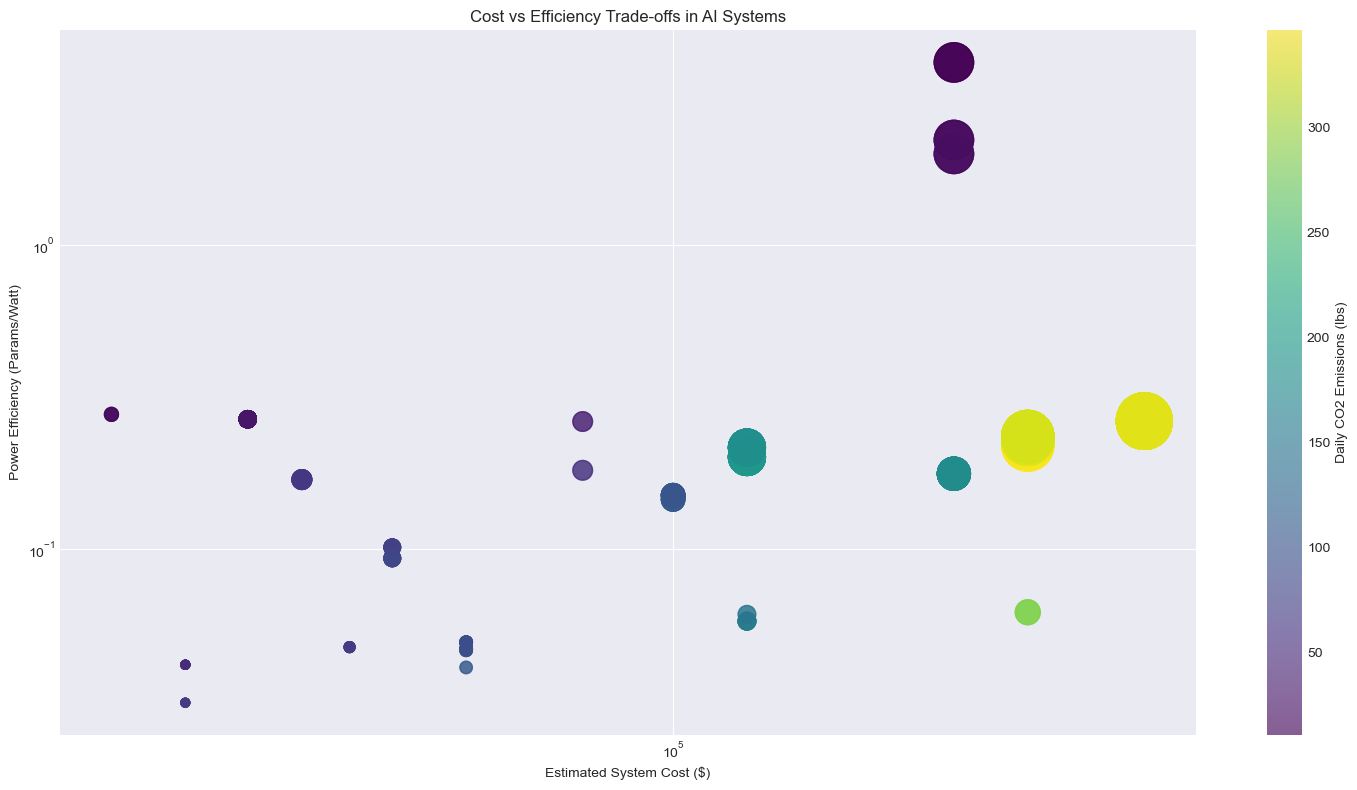

In [23]:
def analyze_efficiency_tradeoffs():
    """Analyze the trade-offs between power, performance, and cost"""
    # Calculate efficiency metrics
    analysis_df = mlperf_df.copy()
    
    # Power efficiency (FLOPS/Watt estimation)
    analysis_df['power_efficiency'] = analysis_df['params_billions'] / analysis_df['total_power']
    
    # Cost estimation (based on current market prices)
    accelerator_costs = {
        'H100-SXM': 30000,
        'H200-SXM': 40000,
        'H100-PCIe': 25000,
        'L40S': 15000,
        'GH200': 35000,
        'MI300X': 25000,
        'TPU': 20000
    }
    
    # Calculate total system cost
    analysis_df['estimated_cost'] = analysis_df.apply(
        lambda x: sum(cost for acc, cost in accelerator_costs.items() 
                     if acc in str(x['Accelerator'])) * x['# of Accelerators']
        if pd.notna(x['Accelerator']) else 0, axis=1
    )
    
    # Calculate cost efficiency metrics
    analysis_df['params_per_dollar'] = analysis_df['params_billions'] / analysis_df['estimated_cost']
    analysis_df['carbon_per_dollar'] = analysis_df['daily_co2'] / analysis_df['estimated_cost']
    
    return analysis_df

# Run analysis
efficiency_analysis = analyze_efficiency_tradeoffs()

# Create visualization
plt.figure(figsize=(15, 8))
plt.scatter(
    efficiency_analysis['estimated_cost'],
    efficiency_analysis['power_efficiency'],
    s=efficiency_analysis['params_billions'],
    alpha=0.6,
    c=efficiency_analysis['daily_co2'],
    cmap='viridis'
)
plt.colorbar(label='Daily CO2 Emissions (lbs)')
plt.xlabel('Estimated System Cost ($)')
plt.ylabel('Power Efficiency (Params/Watt)')
plt.title('Cost vs Efficiency Trade-offs in AI Systems')
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()
plt.savefig('../images/analysis/cost_efficiency_tradeoff.png')
plt.show()

## Temporal Analysis

In [24]:
def analyze_generational_improvements():
    """Analyze efficiency improvements across hardware generations"""
    gen_analysis = mlperf_df.copy()
    
    # Extract generation information
    gen_analysis['generation'] = gen_analysis['Accelerator'].apply(
        lambda x: 'Previous Gen' if any(old in str(x) for old in ['A100', 'MI200'])
        else 'Current Gen' if any(new in str(x) for new in ['H100', 'H200', 'MI300'])
        else 'Other'
    )
    
    # Calculate average metrics by generation
    gen_metrics = gen_analysis.groupby('generation').agg({
        'power_per_billion_params': 'mean',
        'co2_per_billion_params': 'mean',
        'params_billions': 'mean',
        'total_power': 'mean'
    }).round(2)
    
    return gen_metrics

generation_analysis = analyze_generational_improvements()
print("\nGenerational Improvements in Efficiency:")
print(generation_analysis)


Generational Improvements in Efficiency:
             power_per_billion_params  co2_per_billion_params  \
generation                                                      
Current Gen                     33.82                     inf   
Other                             inf                     inf   

             params_billions  total_power  
generation                                 
Current Gen           904.41      4125.43  
Other                  42.86      1078.51  


## Geographic Optimization Analysis

In [25]:
def analyze_optimal_locations():
    """Analyze optimal locations for AI workloads"""
    # Combine power consumption with geographic emissions
    location_analysis = pd.DataFrame()
    
    # Calculate emissions for each state for a standard workload
    for state in state_stats.index:
        emissions_rate = state_stats.loc[state, (emissions_col, 'mean')]
        state_impact = pd.DataFrame({
            'state': state,
            'emissions_rate': emissions_rate,
            'daily_emissions_small': calculate_daily_carbon(2000, emissions_rate),
            'daily_emissions_medium': calculate_daily_carbon(6000, emissions_rate),
            'daily_emissions_large': calculate_daily_carbon(12000, emissions_rate)
        }, index=[0])
        location_analysis = pd.concat([location_analysis, state_impact])
    
    # Calculate potential savings
    max_emissions = location_analysis['daily_emissions_large'].max()
    location_analysis['potential_savings'] = max_emissions - location_analysis['daily_emissions_large']
    
    return location_analysis.sort_values('emissions_rate')

location_optimization = analyze_optimal_locations()
print("\nTop 5 States for AI Workload Optimization:")
print(location_optimization.head())


Top 5 States for AI Workload Optimization:
  state  emissions_rate  daily_emissions_small  daily_emissions_medium  \
0    OR          431.09               20.69232                62.07696   
0    NV          434.92               20.87616                62.62848   
0    ID          446.23               21.41904                64.25712   
0    RI          665.04               31.92192                95.76576   
0    CA          732.03               35.13744               105.41232   

   daily_emissions_large  potential_savings  
0              124.15392          528.67296  
0              125.25696          527.56992  
0              128.51424          524.31264  
0              191.53152          461.29536  
0              210.82464          442.00224  
